## Ground Control Stations

This notebook serves to get familiar with the simulator

In [1]:
from collections import Counter

from config import Color
from helpers import clean  #, local2global
from mavlink.customtypes.location import ENUPose, GRAPose
from plan import Plan
from simulator import (
    QGC,
    ConfigGazebo,
    ConfigNovis,
    ConfigQGC,
    Gazebo,
    NoVisualizer,
    Simulator,
)

clean()

## Simulation Configuration

We can extend Notebook 3 to multiple GCSs by defining the list of UAVs corresponding to each GCS using `gcs_sysids`.  
Each GCS must be assigned a name. For simplicity and better visualization, we name them using colors.  
 

In [2]:
gra_origin = GRAPose(lat=-35.3633280, lon=149.1652241,alt=0,heading=90) 
enu_origin = ENUPose(x=0, y=0, z=gra_origin.alt, heading=gra_origin.heading) 

base_homes= ENUPose.list([  # east, north, up, heading
    (0., 15., 0., 30.),
    (15., 0., 0., 0),
    (-15., -15., 0., 0),
    (-15., 0., 0., 45),
    (5., -20., 0., 0.),
])
base_paths = [Plan.create_square_path(side_len=10, alt=5,heading=0) for _ in base_homes]

gcs_colors=[Color.BLUE,Color.RED]
gcs_names = [f"{color.name}_{color.emoji}" for color in gcs_colors]
gcs_sysids = [[1,2,3],[4,5]]

## Visualizer

For visualization propouses we colored each uav the same color than the GCS they belongs to

In [3]:
uav_colors=list(Counter({color:len(sysids) 
                    for color, sysids in zip(gcs_colors, gcs_sysids)}).elements())

## Gazebo Configuration

Here we color each UAV with the color of the GCS it belongs to.

In [4]:
gaz_config = ConfigGazebo(origin = enu_origin,
                          world_path="simulator/gazebo/worlds/runway.world")

for path,home,c in zip(base_paths,base_homes,uav_colors):
    gaz_config.add(base_path=path,base_home=home,color=c)
gaz_config.show()

gaz= Gazebo(gaz_config,gra_origin)

## QGroundControl

In [5]:
qgc_config = ConfigQGC(origin = gra_origin)

for path,home,color in zip(base_paths,base_homes,uav_colors):
    qgc_config.add(base_path=path,base_home=home,color=color)

qgc_config.show()


qgc=QGC(qgc_config)

# No Simulator

In [6]:
novis_config = ConfigNovis(origin=gra_origin)
for home in base_homes:
    novis_config.add(base_home=home)

novis=NoVisualizer(novis_config)

## Launch Simulation

**Here we configure the simulation:**
* **visualizers**: Select the desired visualizer for the simulation (only one visualizer at a time is currently supported).  
* **gcs_names**: List of GCS names.  
* **gcs_sysids**: A list of lists of UAVs. Each inner list enumerates the system IDs (sysids) for a given GCS. The length of the outer list must match the length of `gcs_names`.  
* **missions**: List of missions for each UAV. Although advanced, customized missions can be built using the `Mission` class defined in the QGroundControl configuration script, here we use the QGroundControl configuration builder for simplicity.  
* **terminals**: Processes to display in the terminal. The available processes are defined in the `sim.py` script: `["launcher", "veh", "logic", "proxy", "gcs"]`.  
* **suppress_output**: Processes whose output should be suppressed. The available processes are defined in the `sim.py` script: `["launcher", "veh", "logic", "proxy", "gcs"]`.  
* **verbose**: Verbosity level (0 = no information, 1 = normal information, 2 = include debugging information).  
* **other arguments**: More advanced options that allow further customization.  

In [7]:
simulator = Simulator(
	visualizers=[gaz],
	gcs_names=gcs_names,
	gcs_sysids=gcs_sysids,
	missions=[veh.mission for veh in qgc_config.vehicles],
	terminals=['gcs'],
	verbose=1,
)

orac = simulator.launch()

18:38:42 - Oracle ⚪ - INFO - 🖥️  Gazebo launched for realistic simulation and 3D visualization.
18:38:42 - Oracle ⚪ - INFO - 🚀 GCS BLUE_🟦 launched (PID 394537)
18:38:42 - Oracle ⚪ - INFO - 🚀 GCS RED_🟥 launched (PID 394540)
18:38:42 - Oracle ⚪ - INFO - ⏳ Waiting for GCS processes to launch vehicles...
18:38:47 - Oracle ⚪ - INFO - 🔗 Starting Oracle connections to vehicles...
18:38:48 - Oracle ⚪ - INFO - 🔗 UAV logic 3 is connected to Oracle ⚪
18:38:48 - Oracle ⚪ - INFO - 🔗 UAV logic 1 is connected to Oracle ⚪
18:38:48 - Oracle ⚪ - INFO - 🔗 UAV logic 4 is connected to Oracle ⚪
18:38:48 - Oracle ⚪ - INFO - 🔗 UAV logic 2 is connected to Oracle ⚪
18:38:48 - Oracle ⚪ - INFO - 🔗 UAV logic 5 is connected to Oracle ⚪


## Oracle checking

In [8]:
orac.run()

18:38:48 - Oracle ⚪ - INFO - 🏁 Starting Oracle with 5 vehicles
18:38:48 - Oracle ⚪ - INFO - Monitoring 2 GCS processes
18:40:09 - Oracle ⚪ - INFO - Received message 'DONE' from GCS RED_🟥
18:40:09 - Oracle ⚪ - INFO - GCS RED_🟥 removal complete. Remaining connections: 3
18:40:12 - Oracle ⚪ - INFO - Received message 'DONE' from GCS BLUE_🟦
18:40:12 - Oracle ⚪ - INFO - GCS BLUE_🟦 removal complete. Remaining connections: 0
18:40:12 - Oracle ⚪ - INFO - ✅ Main monitoring loop completed - all connections closed
18:40:12 - Oracle ⚪ - INFO - 🎉 Oracle shutdown complete!


## Plot gathered positions

Note: We have to name the GCS as "color_*" to make this work

18:40:12 - Oracle ⚪ - INFO - Found 2 trajectory files


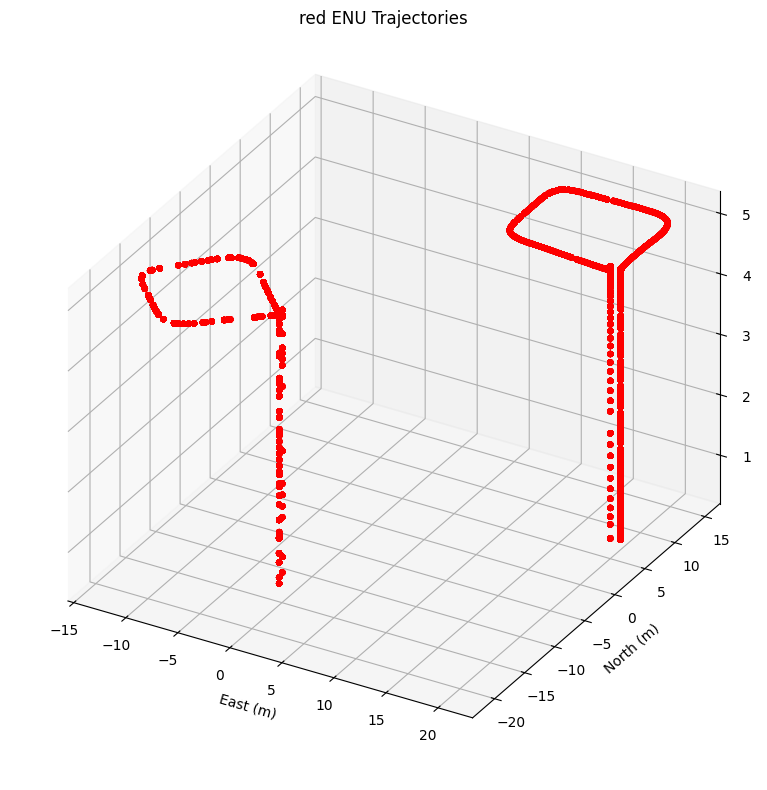

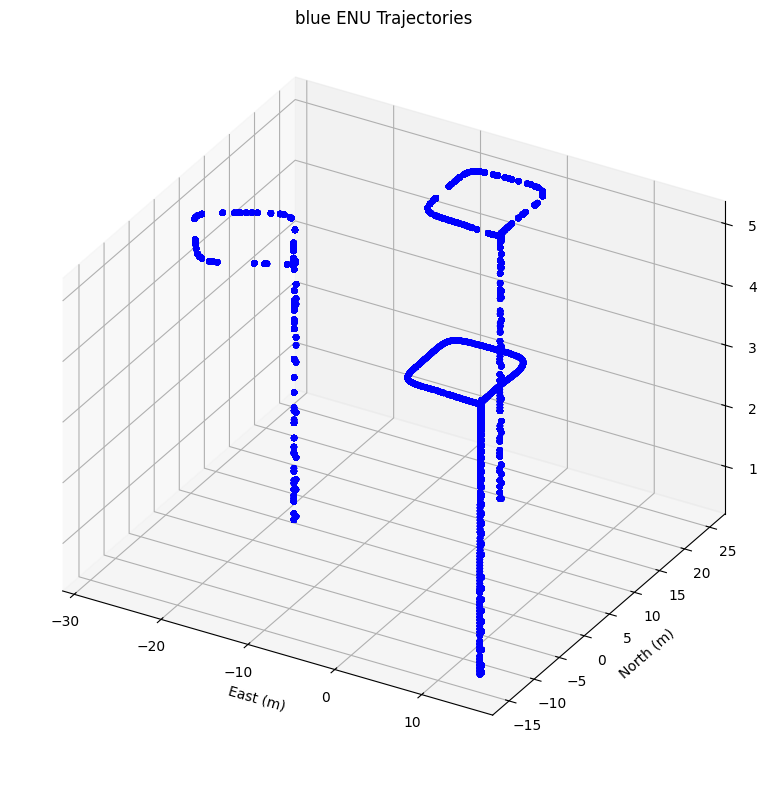

In [ ]:
orac.wait_for_trajectory_files()
orac.plot_trajectories(gra_origin)